
# Biostat 682 — Lecture 13: Bayesian Neural Networks in PyMC  
**Motorcycle data (mcycle.csv): Priors, Posterior Predictive, and LOO elpd**

This notebook reproduces and explains a Bayesian Neural Network (BNN) analysis of the motorcycle dataset.
We compare three priors on the network weights/biases — **Gaussian**, **Laplace**, and **Horseshoe** — using PyMC.
We compute **LOO elpd** for model comparison and **RMSE on the test set** for out-of-sample accuracy, and we visualize posterior predictive bands.



## 0. Environment and versions
We import libraries and print versions for reproducibility.


In [1]:

import sys, numpy as np, pandas as pd, pymc as pm, pytensor.tensor as at, arviz as az
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("PyMC:", pm.__version__)
print("ArviZ:", az.__version__)
print("Matplotlib:", matplotlib.__version__)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Python: 3.9.6
NumPy: 1.24.2
Pandas: 2.3.3
PyMC: 5.12.0
ArviZ: 0.17.1
Matplotlib: 3.7.1



## 1. Load and preprocess data

**Inputs**  
- `mcycle.csv` with columns: `times` and `accel`  
- We rescale `times` to \([0,1]\) and standardize `accel` to zero-mean/unit-variance.

**Train/Test split**  
- Random permutation (seeded)  
- Train: 100; Test: 33


In [3]:

RNG = np.random.default_rng(13)

# Set your path here. If the dataset is not found there, we fall back to /mnt/data.
projpath = "/Users/jiankang/University of Michigan Dropbox/Jian Kang/Umich/Biostat682/Fall2025/data/"
csv_path = projpath + "mcycle.csv"
try:
    df = pd.read_csv(csv_path)
except Exception as e:
    print("Falling back to /mnt/data/mcycle.csv due to:", e)
    csv_path = "/mnt/data/mcycle.csv"
    df = pd.read_csv(csv_path)

assert {"times","accel"}.issubset(df.columns), "CSV must contain 'times' and 'accel'"

x_raw = df["times"].to_numpy().reshape(-1, 1)
y_raw = df["accel"].to_numpy().reshape(-1, 1)

# Rescale X in [0, 1]; standardize Y
x_min, x_max = x_raw.min(), x_raw.max()
X = (x_raw - x_min) / (x_max - x_min)
y_mean, y_std = y_raw.mean(), y_raw.std()
Y = (y_raw - y_mean) / y_std

n = X.shape[0]
idx = RNG.permutation(n)
train_idx, test_idx = idx[:100], idx[100:133]
Xtr, Xte = X[train_idx], X[test_idx]
Ytr, Yte = Y[train_idx], Y[test_idx]

Xtr.shape, Xte.shape, Ytr.shape, Yte.shape


((100, 1), (33, 1), (100, 1), (33, 1))


## 2. Define a BNN builder with selectable priors

We use a 1-hidden-layer network with **tanh** activation and **20 hidden units**:

\[
\mu = \tanh(X W^{(1)} + b^{(1)}) W^{(2)} + b^{(2)},\quad
y \sim \mathcal{N}(\mu, \sigma).
\]

**Priors** (choose one):  
- Gaussian: Normal(0,1)  
- Laplace: Laplace(0,1) (sparser)  
- Horseshoe: global–local shrinkage (Half-Cauchy hyperpriors)


In [11]:

def build_bnn_model(X_data, Y_data, n_hidden=20, prior="gaussian"):
    with pymc.Model() as model:
        # Mutable data containers for train/test swapping
        X_pm = pymc.Data("X", X_data, mutable=True)
        Y_pm = pymc.Data("Y", Y_data, mutable=True)

        if prior == "gaussian":
            W1 = pymc.Normal("W1", 0, 100.0, shape=(1, n_hidden))
            b1 = pymc.Normal("b1", 0, 100.0, shape=(n_hidden,))
            W2 = pymc.Normal("W2", 0, 100.0, shape=(n_hidden, 1))
            b2 = pymc.Normal("b2", 0, 100.0)
        elif prior == "laplace":
            W1 = pymc.Laplace("W1", 0, 100.0, shape=(1, n_hidden))
            b1 = pymc.Laplace("b1", 0, 100.0, shape=(n_hidden,))
            W2 = pymc.Laplace("W2", 0, 100.0, shape=(n_hidden, 1))
            b2 = pymc.Laplace("b2", 0, 100.0)
        elif prior == "horseshoe":
            tau1 = pymc.HalfCauchy("tau1", 1.0)
            tau2 = pymc.HalfCauchy("tau2", 1.0)
            lam1 = pymc.HalfCauchy("lam1", 1.0, shape=(1, n_hidden))
            lam2 = pymc.HalfCauchy("lam2", 1.0, shape=(n_hidden, 1))
            W1 = pymc.Normal("W1", 0, tau1 * lam1)
            b1 = pymc.Normal("b1", 0, tau1, shape=(n_hidden,))
            W2 = pymc.Normal("W2", 0, tau2 * lam2)
            b2 = pymc.Normal("b2", 0, tau2)
        else:
            raise ValueError("prior must be one of {'gaussian','laplace','horseshoe'}")

        act1 = at.tanh(at.dot(X_pm, W1) + b1)
        mu = at.dot(act1, W2) + b2
        sigma = pymc.HalfNormal("sigma", 1.0)

        y_like = pymc.Normal("y_like", mu=mu, sigma=sigma, observed=Y_pm)

    return model



## 3. Helper: robust posterior predictive extractor (InferenceData → NumPy)

PyMC v5 returns posterior predictive as **InferenceData** by default.  
This function:
- stacks `chain, draw → sample`,
- squeezes singleton obs dims,
- stacks multiple obs dims if necessary,
- returns a 2D array of shape `(samples, n_obs)`.


In [12]:

import xarray as xr
import numpy as np

def ppc_idata_to_numpy(ppc_idata, var="y_like", order=None):
    da = ppc_idata.posterior_predictive[var]

    # stack chains & draws to 'sample' if present
    if set(["chain","draw"]).issubset(set(da.dims)):
        da = da.stack(sample=("chain","draw"))

    # squeeze singleton obs dims
    for d in list(da.dims):
        if d != "sample" and da.sizes.get(d, 1) == 1:
            da = da.squeeze(d, drop=True)

    # identify observation dims (anything that's not 'sample')
    obs_dims = [d for d in da.dims if d != "sample"]
    if len(obs_dims) == 0:
        raise ValueError("No observation dimension found in posterior predictive.")
    if len(obs_dims) > 1:
        da = da.stack(obs=tuple(obs_dims))
        obs_name = "obs"
    else:
        obs_name = obs_dims[0]

    # apply ordering on obs axis if provided
    if order is not None:
        da = da.isel({obs_name: order})

    # return (samples, n_obs)
    da = da.transpose("sample", obs_name)
    return da.values



## 4. Fit the BNN under three priors and compute LOO + RMSE
We sample with NUTS and request `log_likelihood` in the `InferenceData` for LOO.
Posterior predictive is computed on both train and test sets. We obtain RMSE on the test set from the posterior predictive mean.


In [14]:

import pymc as pymc

configs = [
    ("gaussian", dict(draws=1000, tune=1000, target_accept=0.95)),
    ("laplace",  dict(draws=1000, tune=1000, target_accept=0.95)),
    ("horseshoe",dict(draws=1000, tune=1000, target_accept=0.95)),
]

results = {}

for prior, kw in configs:
    print(f"\n=== Fitting prior: {prior} ===")
    model = build_bnn_model(Xtr, Ytr, n_hidden=20, prior=prior)
    with model:
        idata = pymc.sample(**kw, chains=3, random_seed=2025,
                            idata_kwargs={"log_likelihood": True})
        # LOO on training fit
        loo = pymc.loo(idata)

        # Posterior predictive on TRAIN (InferenceData)
        ppc_train = pymc.sample_posterior_predictive(idata, var_names=["y_like"])

        # Posterior predictive on TEST (swap data via pm.set_data)
        pymc.set_data({"X": Xte, "Y": Yte})
        ppc_test = pymc.sample_posterior_predictive(idata, var_names=["y_like"])

    # Posterior mean on test and RMSE
    y_draws = ppc_idata_to_numpy(ppc_test, var="y_like")        # (S, n_test)
    yhat_te = y_draws.mean(axis=0).reshape(-1, 1)
    rmse_te = float(np.sqrt(mean_squared_error(Yte, yhat_te)))

    results[prior] = dict(idata=idata, loo=loo, rmse=rmse_te,
                          ppc_train=ppc_train, ppc_test=ppc_test)
    print(f"Prior: {prior:9s} | LOO elpd: {loo.elpd_loo:8.2f} (se {loo.se:6.2f}) | Test RMSE: {rmse_te:.4f}")



=== Fitting prior: gaussian ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [W1, b1, W2, b2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 178 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_like]


Sampling: [y_like]


Prior: gaussian  | LOO elpd:   -75.33 (se   9.09) | Test RMSE: 0.4151

=== Fitting prior: laplace ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [W1, b1, W2, b2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 178 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/jiankang/Dropbox (University of Michigan)/Umich/PythonProjects/pythonProject/venv/lib/python3.9/site-packages/arviz/stats/stats

Sampling: [y_like]


Prior: laplace   | LOO elpd:   -77.48 (se   9.16) | Test RMSE: 0.4209

=== Fitting prior: horseshoe ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [tau1, tau2, lam1, lam2, W1, b1, W2, b2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 250 seconds.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_like]


Sampling: [y_like]


Prior: horseshoe | LOO elpd:   -77.53 (se   9.02) | Test RMSE: 0.4230



## 5. Posterior predictive bands on the test set
We plot the posterior predictive mean and 90% intervals for each prior.


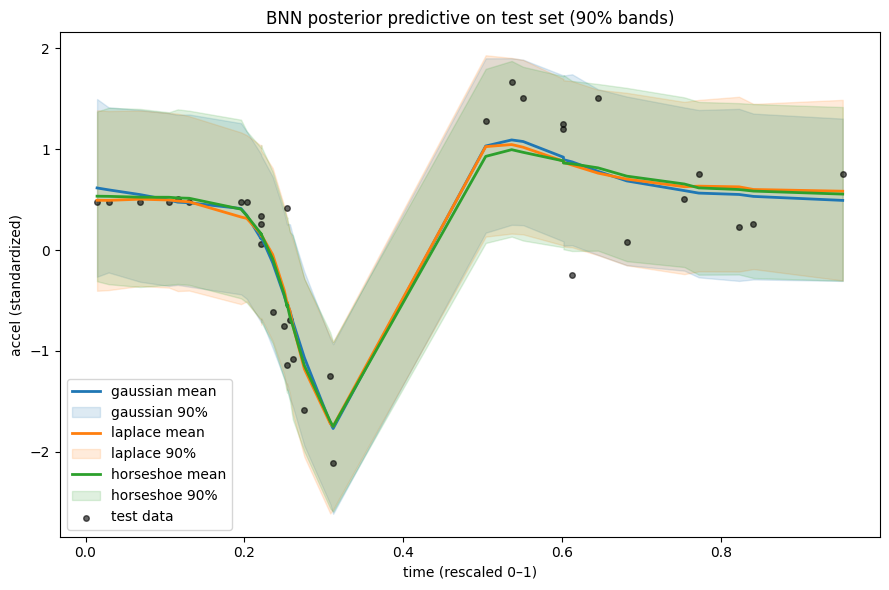

In [15]:

plt.figure(figsize=(9, 6))
order = np.argsort(Xte[:, 0])
x_plot = Xte[order, 0]

for prior, color in zip(["gaussian","laplace","horseshoe"], ["C0","C1","C2"]):
    y_draws = ppc_idata_to_numpy(results[prior]["ppc_test"], var="y_like", order=order)  # (S, n_sorted)
    y_mean = y_draws.mean(axis=0)
    y_lo, y_hi = np.percentile(y_draws, [5, 95], axis=0)
    plt.plot(x_plot, y_mean, label=f"{prior} mean", lw=2, color=color)
    plt.fill_between(x_plot, y_lo, y_hi, alpha=0.15, color=color, label=f"{prior} 90%")

plt.scatter(Xte[:, 0], Yte[:, 0], s=16, c="k", alpha=0.6, label="test data")
plt.xlabel("time (rescaled 0–1)")
plt.ylabel("accel (standardized)")
plt.title("BNN posterior predictive on test set (90% bands)")
plt.legend()
plt.tight_layout()
plt.savefig("BNN_fitting.png", dpi=300)
plt.show()



## 6. Summary: LOO elpd and Test RMSE


In [16]:

print("\n=== Summary ===")
for prior in ["gaussian","laplace","horseshoe"]:
    loo = results[prior]["loo"]
    print(f"{prior:10s}  LOO elpd={loo.elpd_loo:10.2f}   se={loo.se:6.2f}   Test RMSE={results[prior]['rmse']:.4f}")



=== Summary ===
gaussian    LOO elpd=    -75.33   se=  9.09   Test RMSE=0.4151
laplace     LOO elpd=    -77.48   se=  9.16   Test RMSE=0.4209
horseshoe   LOO elpd=    -77.53   se=  9.02   Test RMSE=0.4230



## Appendix: What is LOO elpd?

LOO (leave-one-out) expected log predictive density evaluates predictive accuracy by holding out each observation in turn:
\[
\text{elpd}_{\text{LOO}} = \sum_{i=1}^n \log p(y_i \mid y_{-i})
\]
PyMC computes this efficiently with **Pareto-smoothed importance sampling (PSIS)** via ArviZ (`pm.loo(idata)`).
A **larger** elpd indicates better out-of-sample predictive performance. Compare models with differences in elpd and their standard errors.
